In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = 'cs231n/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment2/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment2


# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from Assignment 1. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.


任务：实现一个有着随机数量隐藏层的全连接的神经网络。

阅读`fc_net.py`文件，实现初始化、前向、后向传播；通过这个作业，实现layers，可重用作业1的类；权重衰退和分批，归一化都不用担心，后面会有。

第一步：将`assignment1`中的`layers.py`文件替换到`assignment2`的`layers.py`。

In [ ]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

完整性检查，运行下面代码检查初始损失，并对是否有正则化的神经网络检查梯度。(查看初始化损失是否有效的方法)

对于梯度检查，应该看误差在1e-7或更小。

第二步：看`fc_net.py`文件，需要完成`{affine-batch/layer_norm-relu-dropout}`一共L-1层，最后一层为`affine-softmax`。


In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.300479089768492
W1 relative error: 1.0252674471656573e-07
W2 relative error: 2.2120479295080622e-05
W3 relative error: 4.5623278736665505e-07
b1 relative error: 4.6600944653202505e-09
b2 relative error: 2.085654276112763e-09
b3 relative error: 1.689724888469736e-10
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 3.904541941902138e-09
W2 relative error: 6.86942277940646e-08
W3 relative error: 3.483989247437803e-08
b1 relative error: 1.4752427965311745e-08
b2 relative error: 1.4615869332918208e-09
b3 relative error: 1.3200479211447775e-10


可以发现，添加了正则化强度的拟合效果更好，主要是误差变小了。

As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

另一个完整性检查，确保神经网络可以在50个图像的小数据集上过拟合。首先，我们将尝试三层神经网络，每个隐藏层有100个单元。在下面的单元格中，将"学习率"和"权重初始化尺度"调整为过拟合，在20个epoch内达到100%的训练准确率。

第三步：修改`weight_scale`和`learning_rate`。

| weight_scale | learning_rate | train_acc | loss |
| ----------- | ----------- | ----------- | ----------- |
| 1e-2 | 1e-4 | 0.20 | 2.2 |
| 2e-2 | 1e-4 | 0.38 | 2.0 |
| 3e-2 | 1e-4 | 0.44 | 3.0 |
| 2e-2 | 2e-4 | 0.62 | 1.6 |
| 2e-2 | 3e-4 | 0.72 | 1.45 |
| 2e-2 | 4e-4 | 0.80 | 1.05 |
| 2e-2 | 1e-3 | 0.98 | 0.489 |
| 2e-2 | 9e-4 | 1.00 | 0.50 |

在`weight_scale`在$0.02$附近最好，`learning_rate`在$0.0009-0.001$左右可以在20epoch得到训练准确率100%，可以选择大于0.001达到过拟合。


(Iteration 1 / 40) loss: 2.738434
(Epoch 0 / 20) train acc: 0.260000; val_acc: 0.098000
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.120000
(Epoch 2 / 20) train acc: 0.560000; val_acc: 0.152000
(Epoch 3 / 20) train acc: 0.700000; val_acc: 0.151000
(Epoch 4 / 20) train acc: 0.840000; val_acc: 0.151000
(Epoch 5 / 20) train acc: 0.780000; val_acc: 0.155000
(Iteration 11 / 40) loss: 0.939644
(Epoch 6 / 20) train acc: 0.880000; val_acc: 0.170000
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.158000
(Epoch 8 / 20) train acc: 0.940000; val_acc: 0.163000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.173000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.168000
(Iteration 21 / 40) loss: 0.390178
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.179000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.167000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.172000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.172000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.173000
(Iteration 31 / 40) loss: 

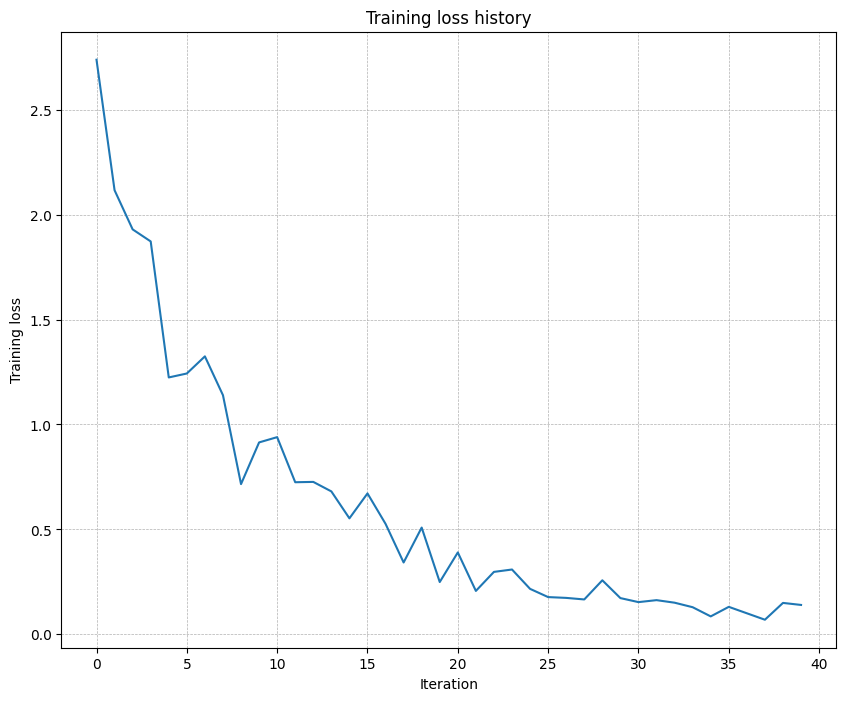

In [ ]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

weight_scale = 2e-2   # Experiment with this!
learning_rate = 2e-3  # Experiment with this!
model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

这里，改为对五层100个节点的神经网络进行50个训练样本的过拟合。

第四步：调整`learning_rate`和`weight_scale`在20epoch内达到100%准确率。

| weight_scale | learning_rate | train_acc | loss |
| ----------- | ----------- | ----------- | ----------- |
| 7e-2 | 6e-4 | 1.00 | 0.035 |
| 7e-2 | 7e-4 | 1.00 | 0.058 |
| 6e-2 | 6e-4 | 0.92 | 0.155 |
| 8e-2 | 6e-4 | 1.00 | 0.009 |
| 1e-3 | 1e-1 | 0.16 | 2.25 |
| 7e-2 | 1e-3 | 1.00 | 0.029 |
| 7e-2 | 1e-2 | 1.00 | 0.111 |

`learning_rate`控制在小于0.012，否则损失会变得很大。

(Iteration 1 / 40) loss: 24.513033
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.109000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.108000
(Epoch 2 / 20) train acc: 0.100000; val_acc: 0.093000
(Epoch 3 / 20) train acc: 0.060000; val_acc: 0.101000
(Epoch 4 / 20) train acc: 0.420000; val_acc: 0.101000
(Epoch 5 / 20) train acc: 0.560000; val_acc: 0.097000
(Iteration 11 / 40) loss: 1.097261
(Epoch 6 / 20) train acc: 0.700000; val_acc: 0.107000
(Epoch 7 / 20) train acc: 0.820000; val_acc: 0.108000
(Epoch 8 / 20) train acc: 0.800000; val_acc: 0.109000
(Epoch 9 / 20) train acc: 0.920000; val_acc: 0.120000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.126000
(Iteration 21 / 40) loss: 0.658782
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.122000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.126000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.120000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.121000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.123000
(Iteration 31 / 40) loss:

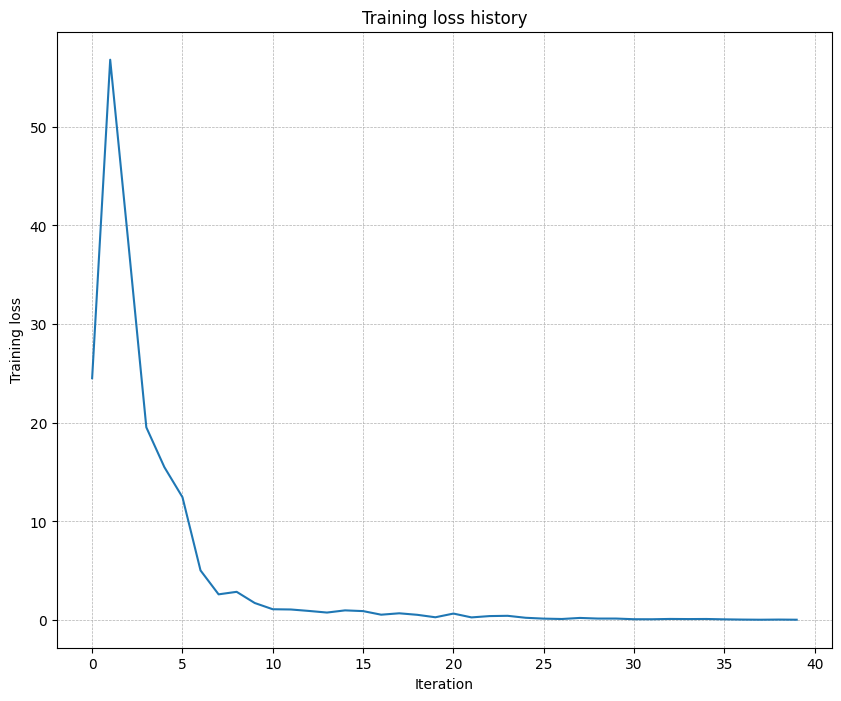

In [ ]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50

small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 7e-2   # Experiment with this!
learning_rate = 1e-2  # Experiment with this!
model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Inline Question 1: 
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
五层神经网络的训练难度更大，对初始化规模更为敏感.
第一是因为随着层数的增加，每层都增加了参数，损失就会比低层数的神经网络在相同波动的情况下，损失更大（不一定高层数的神经网络损失大）。
第二是层数的增加，反向传播中学习率的作用就更大（对更多层进行了学习），所以选择适合的初始化超参数就很重要。


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

使用动量的SGD比普通的SGD在生成深度神经网络中更快。

打开`cs231n/optim.py`并阅读顶部的文件确保理解API。在`sgd_momentum`实现SGD动量的更新规则，并运行下面代码检查错误低于`1e-8`。

第五步：实现`sgd_momentum`。
$$v_i = v_{i-1} - ∇ w_i * \alpha$$
$$w_{i+1} = w_i + v_i$$

梯度下降$w_{i+1} = w_i - \alpha ∇ w_i$，通过给梯度下降增加一个动量。

**使用SGD：**

SGD是对向一个方向移动，GD是向各个方向移动；GD优化一次需要对整个样本集迭代一次，而SGD只对一个样本优化就可以达到同样的效果。SGD相对于GD的另外一个优点是可以跳出局部最小值区域。

**使用动量：**

梯度下降会确保沿着梯度方向进行移动，但是在学习过程中梯度会变得很小，每一次移动的距离也就变小，到达最佳位置的时间就会变长；通过增加动量，让梯度沿着上一次移动的相关的动量与当前的梯度进行移动，减少了到达最佳位置的时间。

所以动量的方法可以让训练和验证比不使用动量更快达到拟合的状态。

In [ ]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

实现后，运行下面六层神经网络，使用SGD、SGD动量。可以看到SGD动量的更新规则收敛更快。

Running with  sgd
(Iteration 1 / 200) loss: 2.488775
(Epoch 0 / 5) train acc: 0.104000; val_acc: 0.125000
(Iteration 11 / 200) loss: 2.251444
(Iteration 21 / 200) loss: 2.284648
(Iteration 31 / 200) loss: 2.267901
(Epoch 1 / 5) train acc: 0.230000; val_acc: 0.233000
(Iteration 41 / 200) loss: 2.135841
(Iteration 51 / 200) loss: 2.111387
(Iteration 61 / 200) loss: 2.099897
(Iteration 71 / 200) loss: 2.033343
(Epoch 2 / 5) train acc: 0.284000; val_acc: 0.267000
(Iteration 81 / 200) loss: 1.950036
(Iteration 91 / 200) loss: 1.939080
(Iteration 101 / 200) loss: 1.935895
(Iteration 111 / 200) loss: 1.936288
(Epoch 3 / 5) train acc: 0.321000; val_acc: 0.279000
(Iteration 121 / 200) loss: 1.841187
(Iteration 131 / 200) loss: 1.953658
(Iteration 141 / 200) loss: 1.898226
(Iteration 151 / 200) loss: 1.880112
(Epoch 4 / 5) train acc: 0.358000; val_acc: 0.296000
(Iteration 161 / 200) loss: 1.862448
(Iteration 171 / 200) loss: 1.845984
(Iteration 181 / 200) loss: 1.865147
(Iteration 191 / 200) los

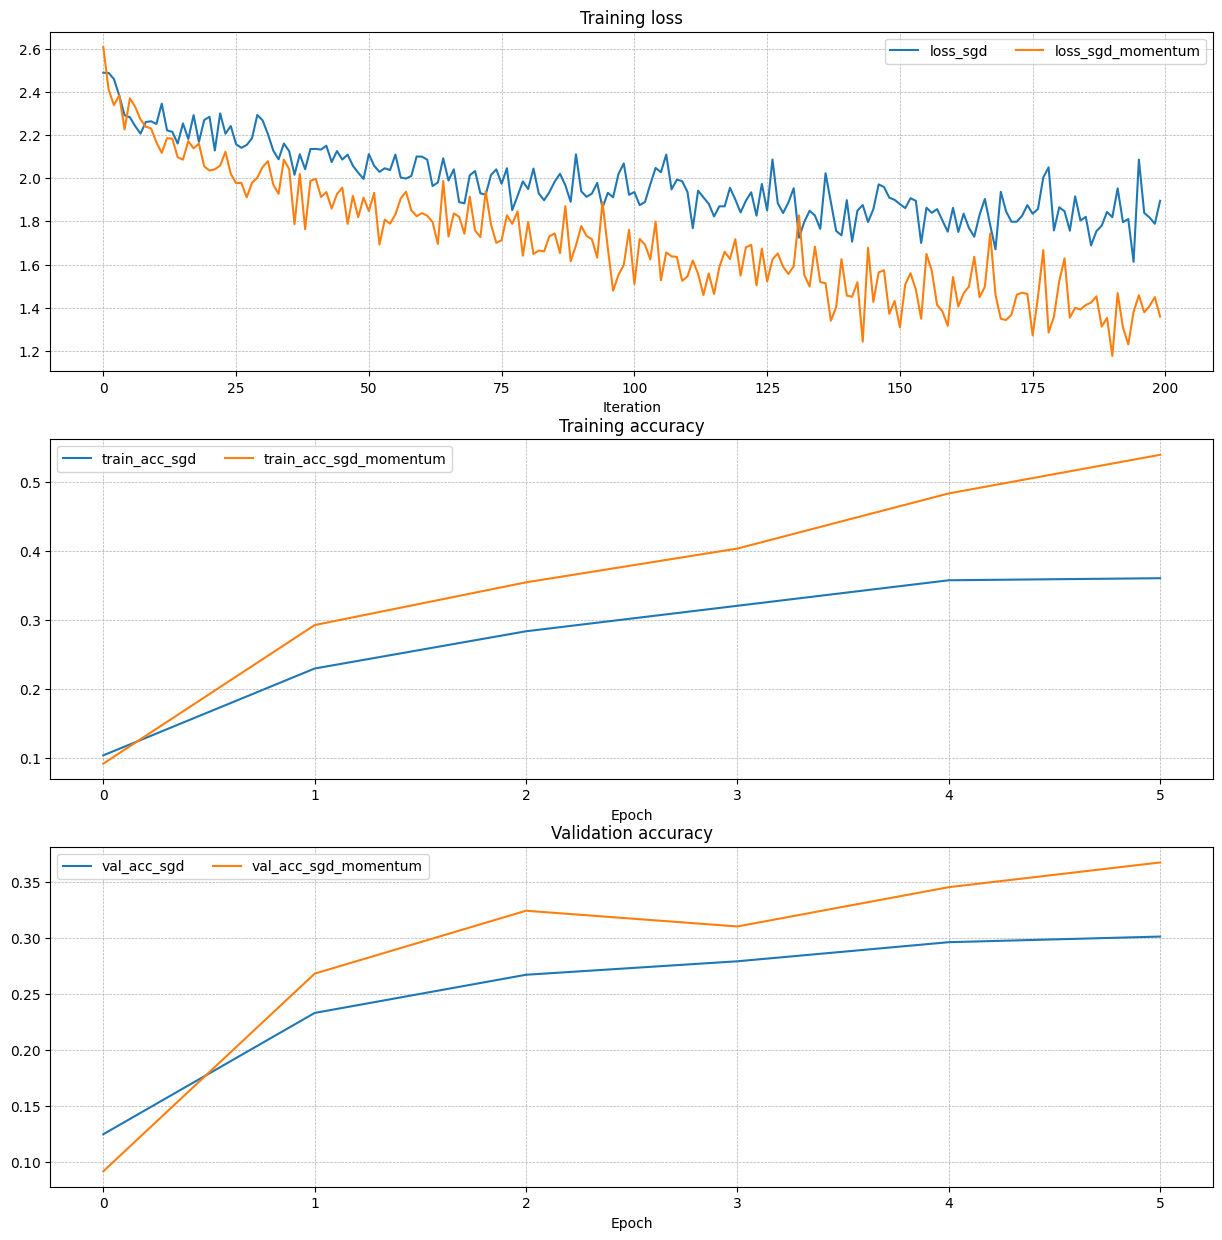

In [ ]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")
    
for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

RMSProp和Adam都是更新规则，通过使用梯度二阶矩的平均值设置每一个学习率。

`cs231n/optim.py`中，在`rmsprop`实现RMSProp，`adam`实现Adam，并且使用下面代码检查实现。

NOTE：实现完全的Adam(带有偏差校正机制)

第六步：实现`rmsprop`和`adam`。

参考资料:[Momentum、RMSProp](https://zhuanlan.zhihu.com/p/42495844)

RMSProp方法：
$$w_{i+1} = w_i - \frac{\alpha ∇ w_i}{\sqrt{s_i }+ ɛ }$$
$$s_i = \beta s_{i-1} + (1-\beta) (∇w)^2$$

In [ ]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


Adam方法：

momentum与PMSProp组合而成。
$$m_{i+1}= \beta_1 m_i +(1-\beta_1)∇w_i$$
$$v_{i+1}= \beta_2 v_i +(1-\beta_2)(∇w_i)^2$$
$$w_{i+1}= w_i - \frac{\alpha\frac{m_{i+1}}{1-\beta_1^t}}{\sqrt{\frac{v_{i+1}}{1-\beta_2^t}}+ɛ}$$
t表示Adam的步数，$\alpha$学习率

In [ ]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 2.775184
(Epoch 0 / 5) train acc: 0.112000; val_acc: 0.091000
(Iteration 11 / 200) loss: 2.033567
(Iteration 21 / 200) loss: 1.897508
(Iteration 31 / 200) loss: 1.859156
(Epoch 1 / 5) train acc: 0.341000; val_acc: 0.314000
(Iteration 41 / 200) loss: 1.815713
(Iteration 51 / 200) loss: 1.762580
(Iteration 61 / 200) loss: 1.757250
(Iteration 71 / 200) loss: 1.653675
(Epoch 2 / 5) train acc: 0.459000; val_acc: 0.350000
(Iteration 81 / 200) loss: 1.571135
(Iteration 91 / 200) loss: 1.449537
(Iteration 101 / 200) loss: 1.606849
(Iteration 111 / 200) loss: 1.477448
(Epoch 3 / 5) train acc: 0.508000; val_acc: 0.372000
(Iteration 121 / 200) loss: 1.541076
(Iteration 131 / 200) loss: 1.342201
(Iteration 141 / 200) loss: 1.520731
(Iteration 151 / 200) loss: 1.367514
(Epoch 4 / 5) train acc: 0.527000; val_acc: 0.352000
(Iteration 161 / 200) loss: 1.420018
(Iteration 171 / 200) loss: 1.441663
(Iteration 181 / 200) loss: 1.292510
(Iteration 191 / 200) lo

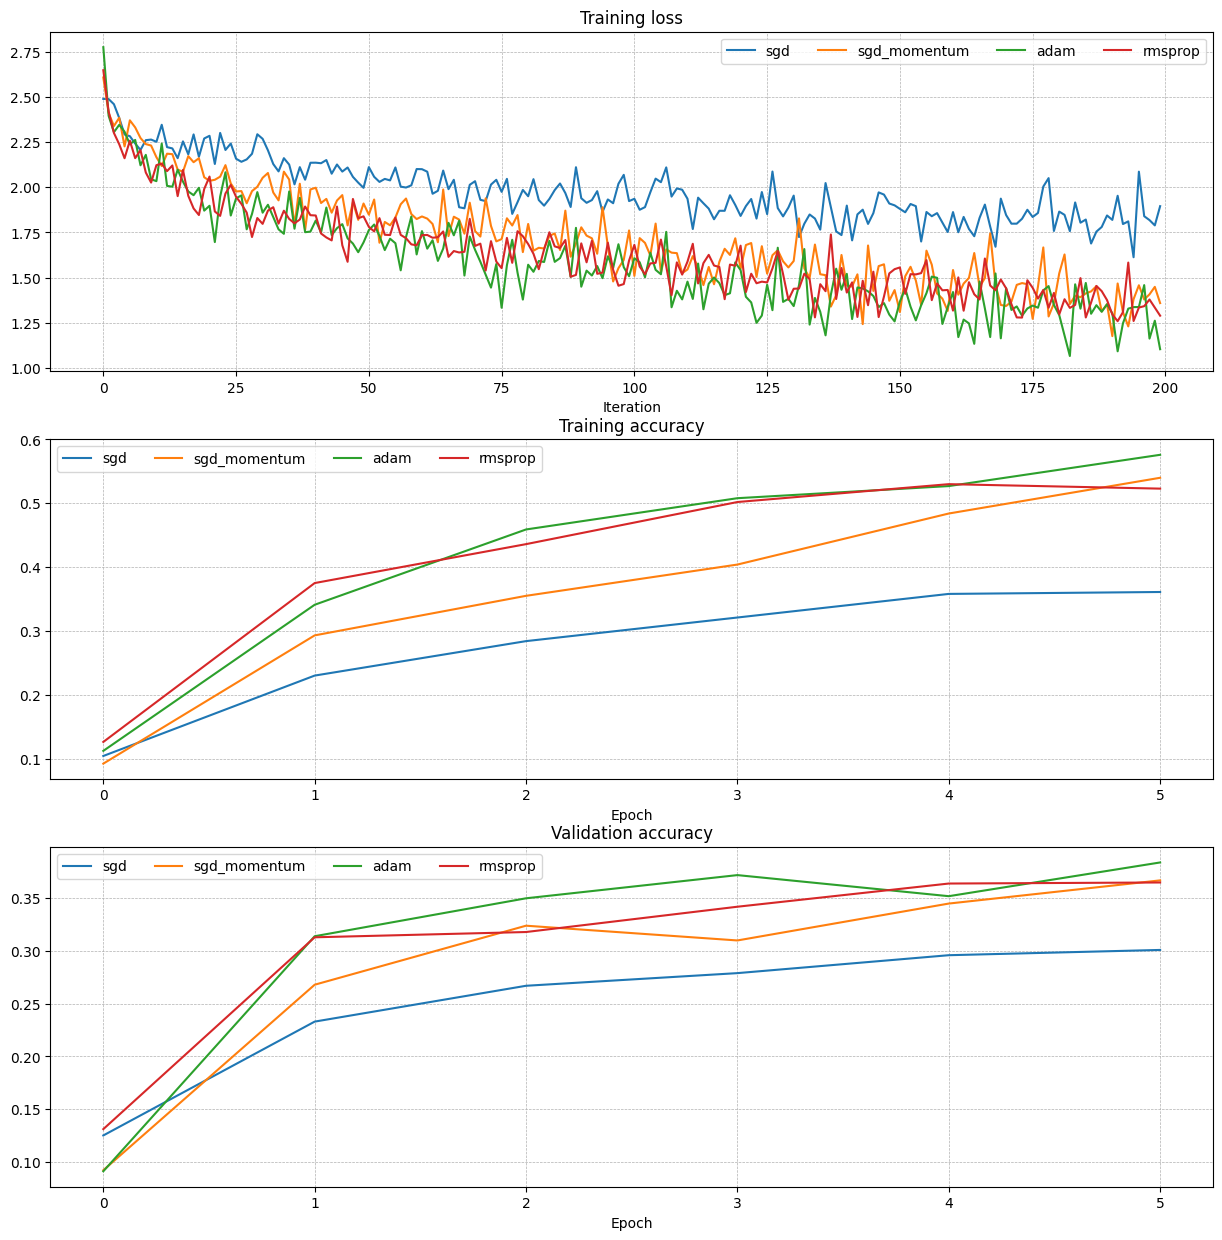

In [ ]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()
    
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## Inline Question 2:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 
AdaGrad：cache因为加上dw的平方项后会变得越来越大，导致分母增加，故导致w每次增量减小。对于凸函数来讲，会在全局最小值处越来越慢，固然很好。但是对于非凸函数，这样的会困在局部最小值处。

对于Adam算法则不会，因为更新之前使用的规则是$m = \frac{m}{1-\beta_1^t}$和$v = \frac{v}{1-\beta_2^t}$。可以看到随着t的增加，使得m和v都在减小，但是更新规则中，分母为$\sqrt{v}+ɛ$，则分母缩小的速度更快，故更新速度不会变慢。



# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

训练在CIFAR-10上最好的全连接神经网络，保持在`best_model`。最少在验证集达到50%准确率。

但主要还是在卷积神经网络，而不是关注全连接神经网络。

第七步：实现下面代码保留最佳全连接神经网络。直接把上面代码拿下来，并改为adam更新规则。

NOTE:提取完成`BatchNormalization`和`Droupout`会对这个部分有提升。

这里只使用small_data训练时，最高验证准确率40%，所以改为data进行训练才能达到目标50%；如果使用了batchnormalization和droupout可以试试在small_data和data上分别运行。

(Iteration 1 / 4900) loss: 2.683663
(Epoch 0 / 10) train acc: 0.113000; val_acc: 0.124000
(Iteration 11 / 4900) loss: 2.130886
(Iteration 21 / 4900) loss: 2.049540
(Iteration 31 / 4900) loss: 1.946901
(Iteration 41 / 4900) loss: 1.880692
(Iteration 51 / 4900) loss: 2.018670
(Iteration 61 / 4900) loss: 1.818432
(Iteration 71 / 4900) loss: 1.688992
(Iteration 81 / 4900) loss: 1.945991
(Iteration 91 / 4900) loss: 1.650149
(Iteration 101 / 4900) loss: 1.707093
(Iteration 111 / 4900) loss: 1.595006
(Iteration 121 / 4900) loss: 1.705784
(Iteration 131 / 4900) loss: 1.870410
(Iteration 141 / 4900) loss: 1.705306
(Iteration 151 / 4900) loss: 1.693574
(Iteration 161 / 4900) loss: 1.800609
(Iteration 171 / 4900) loss: 1.766288
(Iteration 181 / 4900) loss: 1.641547
(Iteration 191 / 4900) loss: 1.787614
(Iteration 201 / 4900) loss: 1.625891
(Iteration 211 / 4900) loss: 1.942718
(Iteration 221 / 4900) loss: 1.808042
(Iteration 231 / 4900) loss: 1.685821
(Iteration 241 / 4900) loss: 1.660005
(Iterat

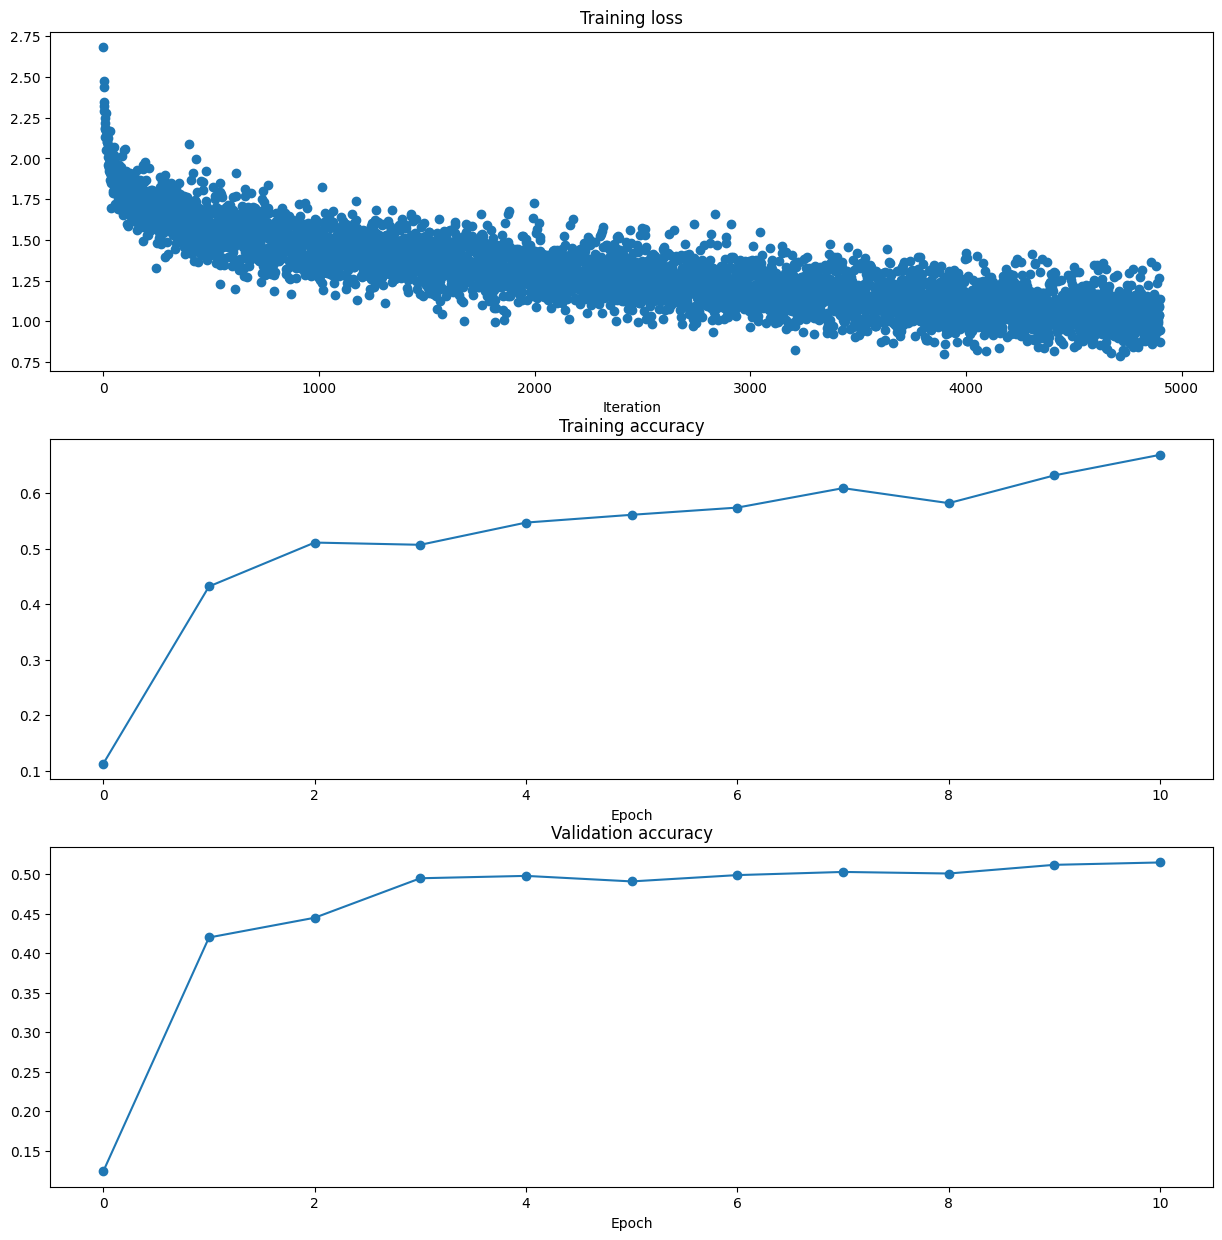

In [ ]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# pass
model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

solver = Solver(model, data,
                num_epochs=10, batch_size=100,
                update_rule='adam',
                optim_config={
                'learning_rate': 1e-3
                },
                lr_decay=0.95,
                verbose=True)
solver.train()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label=update_rule)
  
plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label=update_rule)

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label=update_rule)
plt.gcf().set_size_inches(15, 15)
plt.show()

best_model = model

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set.

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.515
Test set accuracy:  0.491
